In [50]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import yfinance as yf
import matplotlib.pyplot as plt

In [39]:
class MeanVarianceOptimizer:
    def __init__(self, stock_returns):
        """
        Args:
            stock_returns: DataFrame of weekly returns (30 columns = stocks, rows = weeks)
        """
        # Strict 30-stock validation
        if len(stock_returns.columns) != 30:
            raise ValueError(f"Must have exactly 30 stocks. Got {len(stock_returns.columns)}")
            
        self.returns = stock_returns
        self.n_assets = 30
        
        # Compute key parameters
        self.mean_returns = self.returns.mean() * 52  # Annualized
        self.cov_matrix = self.returns.cov() * 52     # Annualized

    def optimize(self, target_return=None, shorting=False):
        """
        Optimize portfolio weights for:
        - Minimum variance (default)
        - Target return (if specified)
        
        Args:
            target_return: Annualized target return (e.g., 0.12 for 12%)
            shorting: Allow negative weights if True
            
        Returns:
            weights: Optimal portfolio weights (30 elements)
            performance: Tuple of (return, volatility)
        """
        # Constraints and bounds
        bounds = [(-1, 1) if shorting else (0, 1) for _ in range(30)]
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
        
        if target_return is not None:
            constraints.append({
                'type': 'eq',
                'fun': lambda x: np.dot(x, self.mean_returns) - target_return
            })

        # Objective function: minimize volatility
        def objective(weights):
            return weights.T @ self.cov_matrix @ weights

        # Optimization
        result = minimize(
            objective,
            x0=np.ones(30)/30,  # Equal initial weights
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 1000}
        )
        
        if not result.success:
            raise ValueError(f"Optimization failed: {result.message}")
            
        weights = result.x
        ret = np.dot(weights, self.mean_returns)
        vol = np.sqrt(weights.T @ self.cov_matrix @ weights)
        
        return weights, (ret, vol)

    def get_min_variance_portfolio(self):
        """Get minimum volatility portfolio"""
        return self.optimize()[0]

    def get_efficient_portfolio(self, target_return):
        """Get portfolio with specific target return"""
        return self.optimize(target_return=target_return)[0]

In [40]:
hist_pct_ret = pd.read_csv('djia_hist_pct_ret.csv')
hist_pct_ret['Date'] = pd.to_datetime(hist_pct_ret['Date'])
hist_pct_ret.set_index('Date', inplace=True, drop=True)
hist_pct_ret

,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,-0.040881,-0.021840,-0.001844,-0.013469,-0.012763,-0.024939,-0.025658,-0.019405,-0.005916,-0.013469,...,-0.023392,-0.018590,-0.022341,-0.032313,-0.009099,-0.011809,-0.017260,-0.006001,-0.018805,-0.011621
2015-01-09,0.024513,-0.026018,-0.037566,-0.025091,0.012235,-0.046038,-0.018231,0.006519,-0.038817,0.005333,...,0.009196,0.010102,-0.009439,-0.002101,0.045649,0.003699,0.029172,-0.016942,0.007521,0.040163
2015-01-16,-0.053745,0.017338,-0.020847,-0.048440,-0.005777,-0.035396,-0.026135,-0.003958,-0.028556,0.009867,...,-0.020132,-0.031254,0.001003,0.011081,-0.002187,0.006709,0.019765,-0.021418,0.026305,-0.028875
2015-01-23,0.065950,0.008711,0.074465,-0.022199,0.029362,0.020869,0.034958,0.019147,0.016457,-0.004833,...,0.020329,0.034090,0.037575,-0.005801,0.000694,0.004317,0.058902,0.013101,-0.017504,0.020053
2015-01-30,0.036998,-0.047244,0.134895,-0.040889,0.079854,-0.065880,-0.037018,-0.065225,-0.040430,-0.039696,...,-0.143705,-0.040662,-0.072912,-0.064276,-0.009999,-0.039065,-0.051339,-0.013086,-0.030541,-0.039883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20,0.025632,-0.026753,-0.011167,-0.011551,0.045388,-0.038028,-0.028980,-0.001706,-0.071619,-0.007178,...,-0.023856,-0.004013,0.003352,-0.017538,-0.052208,-0.022493,-0.039098,0.009436,-0.055582,-0.021326
2024-12-27,0.004322,-0.002772,-0.005202,0.008036,0.019002,-0.003224,-0.015132,0.018626,0.008050,-0.004285,...,-0.013903,-0.006759,0.017149,0.008747,-0.006310,0.002700,0.019715,0.002990,-0.000251,-0.006288
2025-01-03,-0.047850,-0.005444,0.001966,0.009110,-0.059872,-0.002933,-0.016398,-0.005853,0.026736,-0.003496,...,-0.016677,-0.040696,0.054449,-0.025954,-0.019663,0.003645,0.005902,-0.011768,0.008517,-0.009601


In [41]:
irx = yf.download('^IRX', start='2015-01-02', end='2025-01-17', auto_adjust=False)['Adj Close']
irx_weekly = irx.resample('W-FRI').last()  # Take last available rate each week
weekly_rf = (1 + irx_weekly/100)**(1/52) - 1  # Convert annualized discount rate to weekly return
weekly_rf

[*********************100%***********************]  1 of 1 completed


Ticker,^IRX
Date,
2015-01-02,2.884403e-06
2015-01-09,2.884403e-06
2015-01-16,3.461233e-06
2015-01-23,2.499841e-06
2015-01-30,9.615149e-07
...,...
2024-12-20,7.942747e-04
2024-12-27,7.874404e-04
2025-01-03,7.902113e-04


In [42]:
# Initialize optimizer
mvo = MeanVarianceOptimizer(hist_pct_ret)

# Get minimum variance portfolio
min_var_weights = mvo.get_min_variance_portfolio()

# Get portfolio with 12% target return
target_weights = mvo.get_efficient_portfolio(target_return=0.12)

print("Minimum Variance Weights:")
print(np.round(min_var_weights, 4))


Minimum Variance Weights:
[0.     0.     0.0765 0.     0.     0.     0.     0.     0.0127 0.0102
 0.     0.     0.     0.     0.1606 0.     0.0154 0.1301 0.0104 0.1354
 0.     0.     0.     0.1446 0.     0.     0.     0.     0.1599 0.1442]


In [43]:
risk_free_rate = 0.0419  # 5% annualized
djia_weekly_returns = np.array([...])  # Actual 13-week DJIA returns
djia = yf.download('DJIA', start='2025-01-17', end='2025-04-18', auto_adjust=False)['Adj Close']
djia_weekly = djia.resample('W-FRI').last()  # Take last available rate each week
djia_pct_ret = djia_weekly.pct_change().dropna()  
djia_pct_ret

[*********************100%***********************]  1 of 1 completed


Ticker,DJIA
Date,
2025-01-24,0.010279
2025-01-31,0.003493
2025-02-07,0.001741
2025-02-14,0.005213
2025-02-21,-0.014261
2025-02-28,0.011192
2025-03-07,-0.013943
2025-03-14,-0.026513
2025-03-21,0.013618


In [44]:
def calculate_realized_returns(stock_returns, djia_returns, risk_free_rates, risky_weights):
    """
    Calculate realized returns for different risk-free allocations
    
    Args:
        stock_returns: DataFrame of 30 stocks' weekly returns (13 weeks x 30)
        djia_returns: Actual DJIA weekly returns (13 weeks)
        risk_free_rates: Weekly risk-free rates (13 weeks)
        risky_weights: List of allocations to risky portfolio (e.g., [0, 0.5, 1.0])
    
    Returns:
        pd.DataFrame with returns for each allocation
    """
    # Calculate risky portfolio returns (using MVO weights)
    risky_portfolio = stock_returns @ risky_weights  # Weekly returns
    
    # Calculate blended returns for each allocation
    results = []
    for alloc in risky_weights:
        portfolio_returns = alloc * risky_portfolio + (1-alloc) * risk_free_rates
        cum_return = np.prod(1 + portfolio_returns) - 1  # 13-week total
        annualized = (1 + cum_return)**(52/13) - 1  # Convert to annualized
        results.append((alloc, cum_return, annualized))
    
    # DJIA calculations
    djia_cum = np.prod(1 + djia_returns) - 1
    djia_annual = (1 + djia_cum)**(52/13) - 1
    
    return pd.DataFrame(results, columns=['Risky_Allocation', '13-Week_Return', 'Annualized']), djia_cum, djia_annual


In [45]:

def plot_allocations(returns_df, djia_cum, djia_annual):
    """Plot returns across different allocations"""
    plt.figure(figsize=(12, 6))
    
    # Plot 13-week returns
    plt.subplot(1, 2, 1)
    plt.plot(returns_df['Risky_Allocation'], returns_df['13-Week_Return']*100, 
             label='Portfolio', marker='o')
    plt.axhline(y=djia_cum*100, color='r', linestyle='--', label='DJIA')
    plt.title('13-Week Realized Returns')
    plt.xlabel('Risky Allocation (%)')
    plt.ylabel('Return (%)')
    plt.legend()
    
    # Plot annualized returns
    plt.subplot(1, 2, 2)
    plt.plot(returns_df['Risky_Allocation'], returns_df['Annualized']*100, 
             label='Portfolio', marker='o')
    plt.axhline(y=djia_annual*100, color='r', linestyle='--', label='DJIA')
    plt.title('Annualized Equivalent Returns')
    plt.xlabel('Risky Allocation (%)')
    plt.ylabel('Return (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



In [46]:
trade_pct_ret = pd.read_csv('djia_trade_pct_ret.csv')
trade_pct_ret['Date'] = pd.to_datetime(trade_pct_ret['Date'])trade_pct_ret.set_index('Date', inplace=True, drop=True)

In [49]:

# Calculate returns
results_df, djia_13w, djia_ann = calculate_realized_returns(
    stock_returns=trade_pct_ret,
    djia_returns=djia_pct_ret,
    risk_free_rates=0.0419,
    risky_weights=min_var_weights
)

# Display results
print("Portfolio Returns vs DJIA (13 Weeks):")
print(results_df.round(4))
#print(f"\nDJIA 13-Week Return: {djia_13w:.2%}")
#print(f"DJIA Annualized Return: {djia_ann:.2%}")


Portfolio Returns vs DJIA (13 Weeks):
    Risky_Allocation  13-Week_Return  Annualized
0             0.0000          0.7051      7.4519
1             0.0000          0.7051      7.4519
2             0.0765          0.6403      6.2391
3             0.0000          0.7051      7.4519
4             0.0000          0.7051      7.4519
5             0.0000          0.7051      7.4519
6             0.0000          0.7051      7.4519
7             0.0000          0.7051      7.4519
8             0.0127          0.6942      7.2383
9             0.0102          0.6963      7.2799
10            0.0000          0.7051      7.4519
11            0.0000          0.7051      7.4519
12            0.0000          0.7051      7.4519
13            0.0000          0.7051      7.4519
14            0.1606          0.5718      5.1031
15            0.0000          0.7051      7.4519
16            0.0154          0.6918      7.1923
17            0.1301          0.5963      5.4935
18            0.0104          0

/Users/hao/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


NameError: name 'plt' is not defined

In [52]:
def plot_weekly_returns(stock_returns, djia_returns, risk_free_rates, allocations, mvo_weights):
    """
    Plot cumulative returns for different risk-free allocations week-by-week
    
    Args:
        stock_returns: 13 weeks x 30 stocks (DataFrame)
        djia_returns: 13 weekly returns (array)
        risk_free_rates: 13 weekly risk-free rates (array)
        allocations: List like [0.6, 0.7, 0.8] (60/40, 70/30, etc.)
        mvo_weights: Precomputed weights from MVO (30 elements)
    """
    # Calculate base portfolio returns
    risky_returns = stock_returns @ mvo_weights  # Weekly returns (13,)
    
    # Create cumulative return matrix
    cumulative_returns = np.zeros((len(allocations), 14))  # Week 0-13
    plt.figure(figsize=(12, 6))
    
    # Plot each allocation
    for i, alloc in enumerate(allocations):
        # Weekly blended returns
        blended_returns = alloc * risky_returns + (1-alloc) * risk_free_rates
        
        # Cumulative returns (week 1-13)
        cum_ret = np.cumprod(1 + blended_returns) - 1
        cumulative_returns[i, 1:] = cum_ret
        
        # Plot line
        plt.plot(cumulative_returns[i], 
                 label=f'{int(alloc*100)}/{int((1-alloc)*100)} (Risky/Risk-Free)',
                 alpha=0.8)

    # Plot DJIA benchmark
    djia_cum = np.cumprod(1 + djia_returns) - 1
    plt.plot(np.arange(14), np.insert(djia_cum, 0, 0), 
             'k--', lw=2, label='DJIA Benchmark')
    
    plt.title('Cumulative Returns by Risk Allocation (13 Weeks)')
    plt.xlabel('Week')
    plt.ylabel('Cumulative Return')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

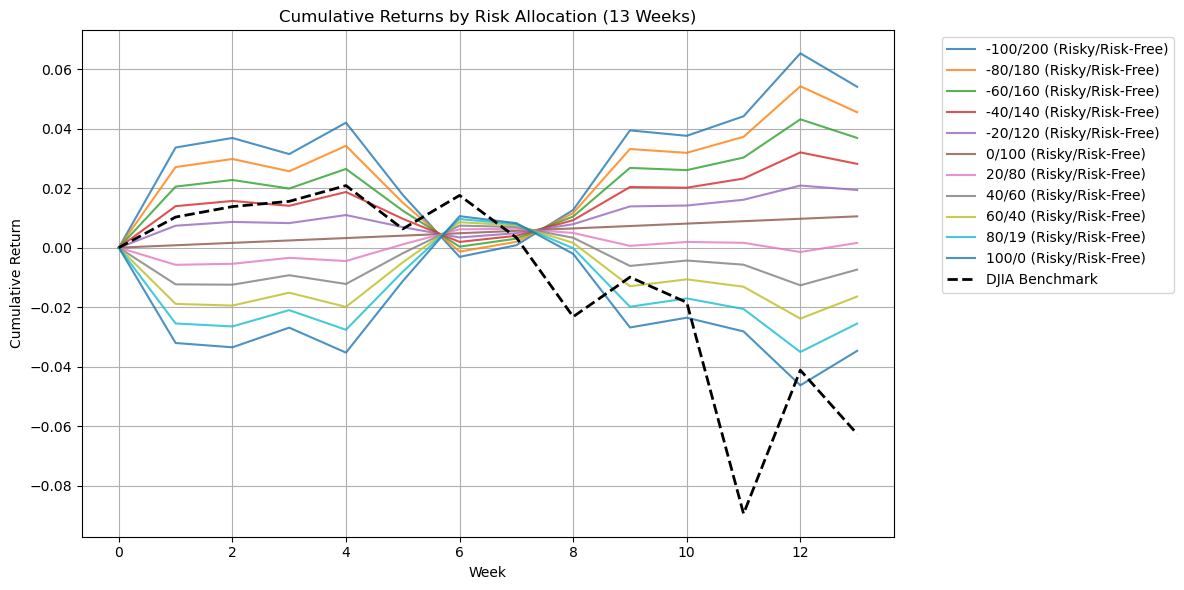

In [54]:

# Required data format:
# - stock_returns: 13 weeks x 30 stocks (DataFrame)
# - djia_returns: 13 weekly returns (array)
# - risk_free: 13 weekly rates (array)
# - mvo_weights: 30-element array

# Example allocations
allocations = [-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0]  # 60/40 through 100/0

plot_weekly_returns(
    stock_returns=hist_pct_ret.iloc[-13:],  # Last 13 weeks
    djia_returns=djia_pct_ret[-13:],
    risk_free_rates=np.full(13, 0.0419/52),  # Annual 4.19% -> weekly
    allocations=allocations,
    mvo_weights=min_var_weights  # From your MVO
)


In [63]:
def compare_risky_weights(stock_returns, djia_returns, risk_free_rates, weight_sets, split=0.6):
    """
    Compare different risky asset weightings within a fixed split
    
    Args:
        stock_returns: 13 weeks x 30 stocks (DataFrame)
        djia_returns: 13 weekly returns (array)
        risk_free_rates: 13 weekly rates (array)
        weight_sets: List of weight arrays from MVO
        split: Risky/Risk-free ratio (0.6 = 60/40)
    """
    plt.figure(figsize=(12, 6))
    
    # Plot each set of risky weights
    for i, weights in enumerate(weight_sets):
        # Calculate risky portfolio returns
        risky_returns = stock_returns @ weights
        
        # Blend with risk-free at 60/40 ratio
        blended_returns = split * risky_returns + (1-split) * risk_free_rates
        
        # Cumulative returns
        cum_ret = np.cumprod(1 + blended_returns) - 1
        plt.plot(np.arange(14), np.insert(cum_ret, 0, 0),
                label=target_labels[i], alpha=0.8)

    # Plot DJIA benchmark
    djia_cum = np.cumprod(1 + djia_returns) - 1
    plt.plot(np.arange(14), np.insert(djia_cum, 0, 0), 
             'k--', lw=2, label='DJIA Benchmark')
    
    plt.title(f'60/40 Portfolio with Different Risky Weightings (13 Weeks)')
    plt.xlabel('Week')
    plt.ylabel('Cumulative Return')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


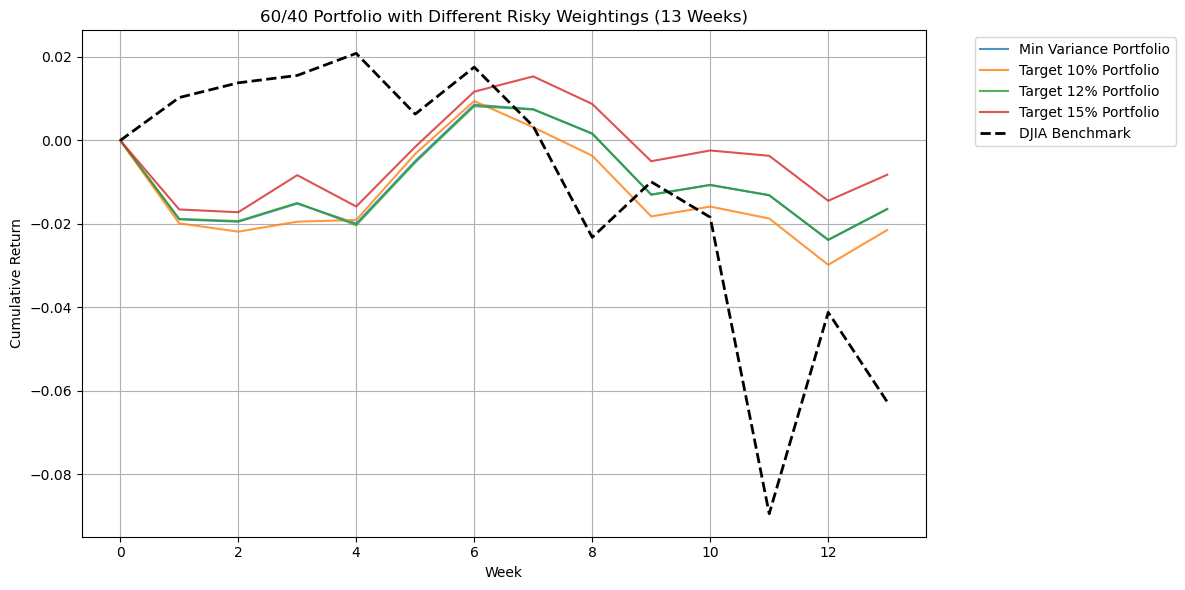

In [64]:
# Generate different target portfolios
target_returns = [0.10, 0.12, 0.15]  # 10%, 12%, 15% annual targets
weight_sets = [mvo.get_efficient_portfolio(target_return=r) for r in target_returns]
target_labels = [
    'Min Variance Portfolio',
    'Target 10% Portfolio',
    'Target 12% Portfolio',
    'Target 15% Portfolio'
]

# Add minimum variance portfolio for comparison
weight_sets.insert(0, mvo.get_min_variance_portfolio())

# Plot comparison
compare_risky_weights(
    stock_returns=hist_pct_ret.iloc[-13:],
    djia_returns=djia_pct_ret[-13:],
    risk_free_rates=np.full(13, 0.0419/52),
    weight_sets=weight_sets,
    split=0.6
)

In [ ]:

# --------------------------------------------------
# Optional: Return Comparison Table
# --------------------------------------------------
def generate_comparison_table(stock_returns, risk_free_rates, weight_sets, split=0.6):
    results = []
    for weights in weight_sets:
        risky_ret = stock_returns @ weights
        blended_ret = split * risky_ret + (1-split) * risk_free_rates
        cum_ret = np.prod(1 + blended_ret) - 1
        ann_ret = (1 + cum_ret)**(52/13) - 1
        results.append([weights.mean(), weights.std(), cum_ret, ann_ret])
    
    return pd.DataFrame(
        results,
        columns=['Avg Weight', 'Weight Vol', '13-Week Return', 'Annualized'],
        index=[f'Portfolio {i+1}' for i in range(len(weight_sets))]
    )

print(generate_comparison_table(
    hist_pct_ret.iloc[-13:],
    np.full(13, 0.0419/52),
    weight_sets
).round(4))
